##### Copyright 2020 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
#albertrocapedrs
#ecd09c4410ced671f04ac5a2d3a18b52

## Setup

Import necessary modules and dependencies. You'll be using `tf.keras.utils.audio_dataset_from_directory` (introduced in TensorFlow 2.10), which helps generate audio classification datasets from directories of `.wav` files. You'll also need [seaborn](https://seaborn.pydata.org) for visualization in this tutorial.

In [1]:
#!pip install -U -q tensorflow==2.16.1  tensorflow_datasets
!pip install -q tensorflow_datasets

In [2]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

2025-12-18 17:58:41.806023: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1766080721.967034      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1766080722.013851      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

## Import the Speech Commands dataset

This is the [dataset](https://dax-cdn.cdn.appdomain.cloud/dax-tensorflow-speech-commands/1.0.1/data_preview/index.html) that you will be working on. This dataset consists of 65,000 WAV Files and the audio clips were originally collected by Google, and recorded by volunteers in uncontrolled locations around the world.

In [ ]:
DATASET_PATH = '/kaggle/input/tvd-2025-reconocimiento-de-comandos-de-voz/train/train/audio'

data_dir = pathlib.Path(DATASET_PATH)

The dataset's audio clips are stored in 31 folders corresponding to each speech command. 

- 20 core words: `yes`, `no`, `up`, `down`, `left`,`right`, `on`, `off`, `stop`, `go`, `zero`, `one`,`two`, `three`, `four`, `five`,`six`, `seven`, `eight`, `nine`,   

- 10 auxiliary words: `bed`, `bird`, `cat`, `dog`, `happy`, `house`, `marvin`, `sheila`, `tree` and `wow`
  
- And background noise: `doing_the_dishes`, `dude_miaowing`, `exercise_bike`, `pink_noise`, `running_tap`, and `white_noise`.

In [54]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['no' 'two' 'four' 'five' 'nine' 'right' '_background_noise_' 'off' 'yes'
 'six' 'dog' 'left' 'bird' 'wow' 'zero' 'eight' 'bed' 'go' 'house' 'tree'
 'seven' 'on' 'three' 'one' 'down' 'stop' 'up' 'happy' 'marvin' 'cat'
 'sheila']


Divided into directories this way, you can easily load the data using `keras.utils.audio_dataset_from_directory`.

The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [55]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 64727 files belonging to 31 classes.
Using 51782 files for training.
Using 12945 files for validation.

label names: ['_background_noise_' 'bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five'
 'four' 'go' 'happy' 'house' 'left' 'marvin' 'nine' 'no' 'off' 'on' 'one'
 'right' 'seven' 'sheila' 'six' 'stop' 'three' 'tree' 'two' 'up' 'wow'
 'yes' 'zero']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`.

In [56]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [57]:
# Agafar funció
TARGET_LENGTH = 16000     # 1 segon @ 16 kHz
spect_type = "mel" #mel #basic #mfcc


This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [58]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use `Dataset.shard` to split the validation set into two halves. Note that iterating over **any** shard will load **all** the data, and only keep its fraction.

In [59]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [60]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


Let's plot a few audio waveforms:

In [61]:
label_names[[1,1,3,0]]

array(['bed', 'bed', 'cat', '_background_noise_'], dtype='<U18')

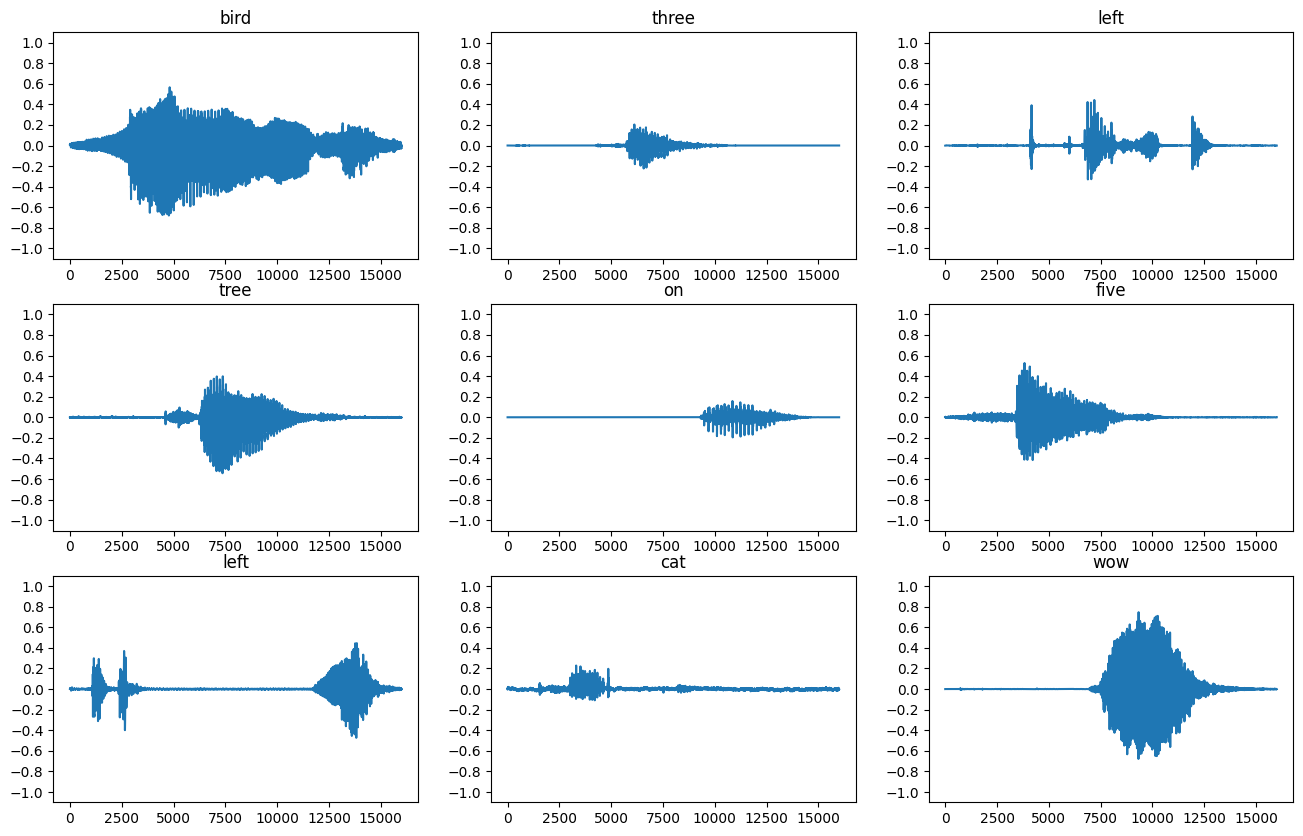

In [62]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  plt.ylim([-1.1, 1.1])

## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [63]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [64]:
def get_mel_spectrogram(waveform,
                        frame_length=255,
                        frame_step=128,
                        num_mel_bins=64,
                        lower_edge_hz=80.0,
                        upper_edge_hz=7600.0,
                        sample_rate=16000):

    # 1. STFT igual que en tu función original
    stft = tf.signal.stft(
        waveform,
        frame_length=frame_length,
        frame_step=frame_step
    )
    magnitude_spectrogram = tf.abs(stft)

    # 2. Crear el banco de filtros Mel
    num_spectrogram_bins = magnitude_spectrogram.shape[-1]
    mel_filterbank = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins,
        num_spectrogram_bins,
        sample_rate,
        lower_edge_hz,
        upper_edge_hz
    )

    # 3. Aplicar el banco de filtros para obtener el espectrograma Mel
    mel_spectrogram = tf.matmul(magnitude_spectrogram, mel_filterbank)

    # 4. Añadir dimensión de canal (igual que tu función original)
    mel_spectrogram = mel_spectrogram[..., tf.newaxis]

    return mel_spectrogram

In [65]:
def get_mfcc(waveform,
             frame_length=255,
             frame_step=128,
             num_mel_bins=64,
             num_mfcc=13,
             lower_edge_hz=80.0,
             upper_edge_hz=7600.0,
             sample_rate=16000):
    """
    Genera coeficientes MFCC a partir de un waveform.
    Mantiene la estructura de las funciones anteriores.
    """

    # 1. STFT
    stft = tf.signal.stft(
        waveform,
        frame_length=frame_length,
        frame_step=frame_step
    )
    magnitude_spectrogram = tf.abs(stft)

    # 2. Banco Mel
    num_spectrogram_bins = magnitude_spectrogram.shape[-1]
    mel_filterbank = tf.signal.linear_to_mel_weight_matrix(
        num_mel_bins,
        num_spectrogram_bins,
        sample_rate,
        lower_edge_hz,
        upper_edge_hz
    )

    mel_spectrogram = tf.matmul(magnitude_spectrogram, mel_filterbank)

    # 3. Log-Mel (recomendado para MFCC)
    log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)

    # 4. MFCC
    mfccs = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrogram)
    mfccs = mfccs[..., :num_mfcc]  # quedarse con los primeros coeficientes

    # 5. Añadir dimensión de canal
    mfccs = mfccs[..., tf.newaxis]

    return mfccs

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [66]:
if spect_type == "basic":
    for i in range(3):
          label = label_names[example_labels[i]]
          waveform = example_audio[i]
          spectrogram = get_spectrogram(waveform)
        
          print('Label:', label)
          print('Waveform shape:', waveform.shape)
          print('Spectrogram shape:', spectrogram.shape)
          print('Audio playback')
          display.display(display.Audio(waveform, rate=16000))
if spect_type == "mel":
    for i in range(3):
          label = label_names[example_labels[i]]
          waveform = example_audio[i]
          spectrogram = get_mel_spectrogram(waveform)
        
          print('Label:', label)
          print('Waveform shape:', waveform.shape)
          print('Spectrogram shape:', spectrogram.shape)
          print('Audio playback')
          display.display(display.Audio(waveform, rate=16000))
if spect_type == "mfcc":
    for i in range(3):
          label = label_names[example_labels[i]]
          waveform = example_audio[i]
          spectrogram = get_mfcc(waveform)
        
          print('Label:', label)
          print('Waveform shape:', waveform.shape)
          print('Spectrogram shape:', spectrogram.shape)
          print('Audio playback')
          display.display(display.Audio(waveform, rate=16000))

Label: bird
Waveform shape: (16000,)
Spectrogram shape: (124, 64, 1)
Audio playback


Label: three
Waveform shape: (16000,)
Spectrogram shape: (124, 64, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (124, 64, 1)
Audio playback


Now, define a function for displaying a spectrogram:

In [67]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

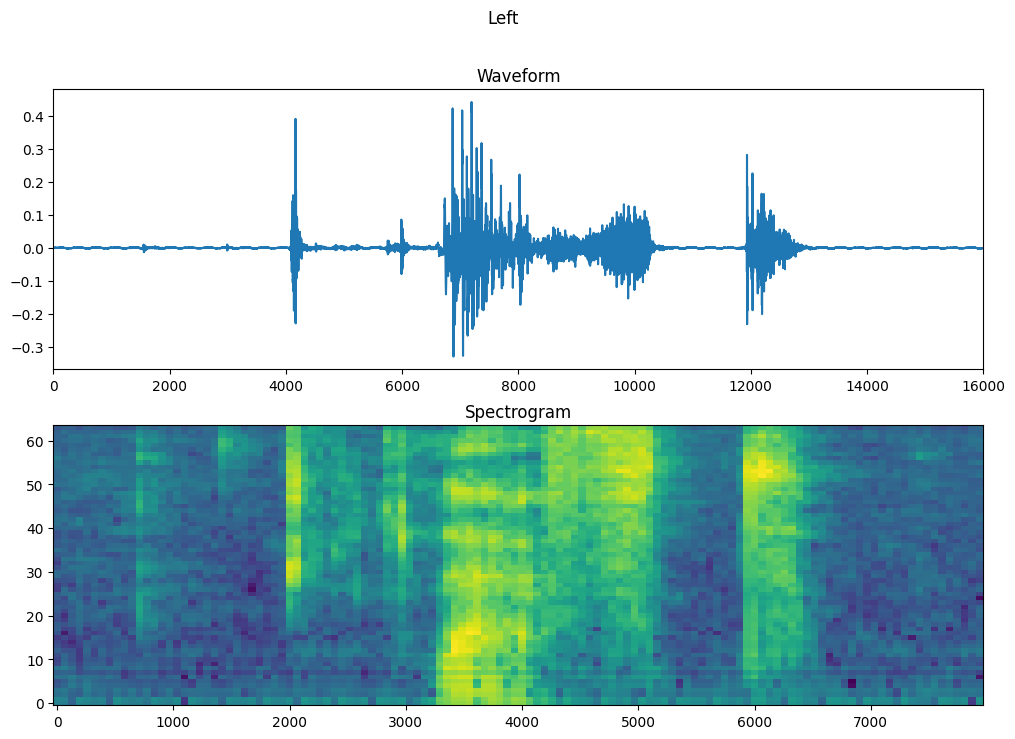

In [68]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogram datasets from the audio datasets:

In [69]:
def make_spec_ds(ds):
    if spect_type == "basic":
        return ds.map(
          map_func=lambda audio,label: (get_spectrogram(audio), label),
          num_parallel_calls=tf.data.AUTOTUNE)
    elif spect_type == "mel":
        return ds.map(
          map_func=lambda audio,label: (get_mel_spectrogram(audio), label),
          num_parallel_calls=tf.data.AUTOTUNE)
    elif spect_type == "mfcc":
        return ds.map(
          map_func=lambda audio,label: (get_mfcc(audio), label),
          num_parallel_calls=tf.data.AUTOTUNE)


In [70]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [71]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

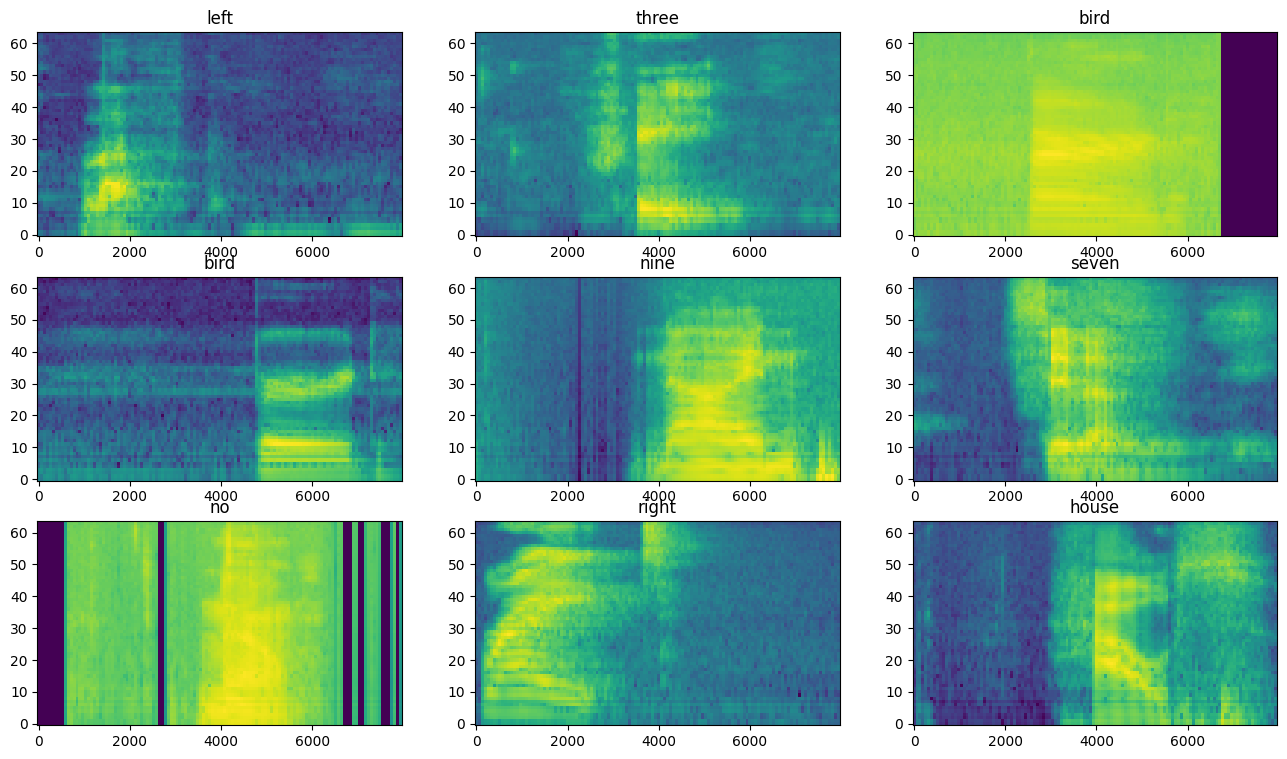

In [72]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Build and train the model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [73]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [74]:
# We provide some function you may find useful for your models

class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.ffn = Sequential(
            [
                layers.Dense(ff_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, inputs):
        maxlen = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        position_embeddings = self.pos_emb(positions)
        token_embeddings = self.token_emb(inputs)
        return token_embeddings + position_embeddings

# **Modelo Base** 

In [75]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(num_labels),
])

model.summary()
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)
EPOCHS = 20
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Input shape: (124, 64, 1)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_2 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_2 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       460,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 31)             │         2,015 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 463,202 (1.77 MB)

 Trainable params: 463,199 (1.77 MB)

 Non-trainable params: 3 (16.00 B)

Epoch 1/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - accuracy: 0.2873 - loss: 2.5629 - val_accuracy: 0.5657 - val_loss: 1.5415
Epoch 2/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6256 - loss: 1.3583 - val_accuracy: 0.6623 - val_loss: 1.1828
Epoch 3/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7171 - loss: 1.0070 - val_accuracy: 0.7127 - val_loss: 1.0292
Epoch 4/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7709 - loss: 0.8193 - val_accuracy: 0.7384 - val_loss: 0.9491
Epoch 5/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7976 - loss: 0.7085 - val_accuracy: 0.7608 - val_loss: 0.8976
Epoch 6/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8262 - loss: 0.6149 - val_accuracy: 0.7741 - val_loss: 0.8874
Epoch 7/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8431 - loss: 0.5448 - val_accuracy: 0.7782 - val_loss: 0.8803
Epoch 8/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8585 - loss: 0.4933 - val_accuracy: 

### Modelo CNN básico con Dropout

Este modelo es una extensión directa del modelo CNN base, en el que se añade una capa de **Dropout (0.3)** como técnica de regularización.  
La arquitectura se mantiene idéntica para poder comparar de forma justa el impacto del Dropout sobre el rendimiento.

**Estructura del modelo:**
- Entrada: espectrogramas de audio
- Redimensionado a 32 × 32
- Normalización de los datos
- Capa convolucional 2D (32 filtros, kernel 3×3, ReLU)
- MaxPooling 2D
- Aplanado (Flatten)
- Capa densa (64 neuronas, ReLU)
- Dropout (0.3)
- Capa de salida (Softmax / logits)

**Objetivo:**
Evaluar si la regularización mediante Dropout reduce el sobreajuste y mejora la generalización frente al modelo base sin Dropout.

**Entrenamiento:**
- Optimizador: Adam
- Función de pérdida: Sparse Categorical Crossentropy
- Métrica: Accuracy
- Early Stopping con paciencia 2


In [76]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Normalization layer
norm_layer = layers.Normalization()
norm_layer.adapt(
    data=train_spectrogram_ds.map(lambda spec, label: spec)
)

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input
    layers.Resizing(32, 32),
    # Normalize
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),          # <-- Dropout añadido
    layers.Dense(num_labels),
])

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

EPOCHS = 20
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(
        verbose=1,
        patience=2
    ),
)


Input shape: (124, 64, 1)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing_3 (Resizing)           │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_3 (Normalization) │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 7200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │       460,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 31)             │         2,015 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 463,202 (1.77 MB)

 Trainable params: 463,199 (1.77 MB)

 Non-trainable params: 3 (16.00 B)

Epoch 1/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.1975 - loss: 2.8421 - val_accuracy: 0.5237 - val_loss: 1.7703
Epoch 2/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4555 - loss: 1.8777 - val_accuracy: 0.6411 - val_loss: 1.3631
Epoch 3/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5534 - loss: 1.5129 - val_accuracy: 0.6856 - val_loss: 1.1761
Epoch 4/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6077 - loss: 1.3298 - val_accuracy: 0.7144 - val_loss: 1.0703
Epoch 5/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6394 - loss: 1.2098 - val_accuracy: 0.7194 - val_loss: 1.0444
Epoch 6/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6633 - loss: 1.1217 - val_accuracy: 0.7463 - val_loss: 0.9731
Epoch 7/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6813 - loss: 1.0597 - val_accuracy: 0.7420 - val_loss: 0.9612
Epoch 8/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6935 - loss: 0.9992 - val_accuracy: 0.

# **RNN (BiLSTM)**

**Tipo de modelo:** Red neuronal recurrente pura  
**Entrada:** Mel-espectrogramas  
**Preprocesamiento:** Redimensionado a 96×96 y normalización  

**Arquitectura:**
- Reorganización del espectrograma como secuencia temporal
- Dos capas GRU bidireccionales apiladas
- Capa de dropout para regularización
- Capa densa con activación softmax para clasificación

**Objetivo del modelo:**  
Evaluar la capacidad de las redes recurrentes para modelar dependencias temporales en señales de audio, sin utilizar capas convolucionales ni mecanismos de atención.

**Uso en el trabajo:**  
Modelo de referencia para comparar con arquitecturas CNN, CNN–RNN y Conformer.



In [77]:
import tensorflow as tf
from tensorflow.keras import layers, models

input_shape = example_spectrograms.shape[1:]
num_labels = len(label_names)

# Normalization
norm_layer = layers.Normalization()
norm_layer.adapt(train_spectrogram_ds.map(lambda spec, label: spec))

inputs = layers.Input(shape=input_shape)

# Preprocess
x = layers.Resizing(96, 96)(inputs)
x = norm_layer(x)

# Convert spectrogram to sequence
# (time_steps, features)
x = layers.Reshape((96, 96))(x)

# RNN BLOCK
x = layers.Bidirectional(
    layers.GRU(
        128,
        return_sequences=True
    )
)(x)

x = layers.Bidirectional(
    layers.GRU(
        128,
        return_sequences=False
    )
)(x)

x = layers.Dropout(0.3)(x)

# CLASSIFIER
outputs = layers.Dense(num_labels, activation="softmax")(x)

model_Bilstm = tf.keras.Model(inputs, outputs, name="Bilstm_RNN")
model_Bilstm.summary()


# COMPILE
model_Bilstm.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)


# CALLBACKS
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=7,
        restore_best_weights=True,
        verbose=1
    )
]


# TRAIN
history = model_Bilstm.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=20,
    callbacks=callbacks
)


Model: "Bilstm_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 124, 64, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_4 (Resizing)           │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_4 (Normalization) │ (None, 96, 96, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 96, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 96, 256)        │       173,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 256)            │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 31)             │         7,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 477,986 (1.82 MB)

 Trainable params: 477,983 (1.82 MB)

 Non-trainable params: 3 (16.00 B)

Epoch 1/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 28s 31ms/step - accuracy: 0.0601 - loss: 3.3363 - val_accuracy: 0.3436 - val_loss: 2.2652
Epoch 2/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - accuracy: 0.3973 - loss: 2.0164 - val_accuracy: 0.6513 - val_loss: 1.2828
Epoch 3/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.6355 - loss: 1.2563 - val_accuracy: 0.7356 - val_loss: 0.9332
Epoch 4/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.7279 - loss: 0.9380 - val_accuracy: 0.7828 - val_loss: 0.7697
Epoch 5/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.7746 - loss: 0.7753 - val_accuracy: 0.8091 - val_loss: 0.6615
Epoch 6/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.8046 - loss: 0.6689 - val_accuracy: 0.8280 - val_loss: 0.5910
Epoch 7/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.8313 - loss: 0.5835 - val_accuracy: 0.8419 - val_loss: 0.5485
Epoch 8/20
810/810 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.8457 - loss: 0.5283 - 

# **RNN (GRU)**
**Tipo de arquitectura:** Red neuronal recurrente pura  
**Entrada:** Mel-espectrogramas  
**Preprocesamiento:** Redimensionado a 96×96 y normalización  

**Estructura del modelo:**
- Conversión del espectrograma en una secuencia temporal (96 pasos, 96 características)
- Dos capas GRU bidireccionales apiladas
- Capa de dropout para regularización
- Capa densa final con activación softmax

**Características principales:**
- Modela dependencias temporales en ambas direcciones (pasado y futuro)
- No utiliza capas convolucionales
- No extrae características espaciales explícitas

**Objetivo del experimento:**  
Analizar el rendimiento de una arquitectura puramente recurrente en reconocimiento de comandos de voz y compararla con modelos CNN y arquitecturas híbridas.


In [78]:
import tensorflow as tf
from tensorflow.keras import layers, models


# BUILD RNN MODEL BiGRU
input_shape = example_spectrograms.shape[1:]
num_labels = len(label_names)

# Normalization
norm_layer = layers.Normalization()
norm_layer.adapt(train_spectrogram_ds.map(lambda spec, label: spec))

inputs = layers.Input(shape=input_shape)

# Preprocess
x = layers.Resizing(96, 96)(inputs)
x = norm_layer(x)

# Convert spectrogram to sequence
# (time_steps, features)
x = layers.Reshape((96, 96))(x)

# ===========================
# RNN BLOCK
# ===========================
x = layers.Bidirectional(
    layers.GRU(
        128,
        return_sequences=True
    )
)(x)

x = layers.Bidirectional(
    layers.GRU(
        128,
        return_sequences=False
    )
)(x)

x = layers.Dropout(0.3)(x)

# ===========================
# CLASSIFIER
# ===========================
outputs = layers.Dense(num_labels, activation="softmax")(x)

model_BiGRU = tf.keras.Model(inputs, outputs, name="BiGRU_RNN")
model_BiGRU.summary()


# ===========================
# COMPILE
# ===========================
model_BiGRU.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)


# ===========================
# CALLBACKS
# ===========================
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=7,
        restore_best_weights=True,
        verbose=1
    )
]


# ===========================
# TRAIN
# ===========================
history = model_BiGRU.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=25,
    callbacks=callbacks
)


Model: "BiGRU_RNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 124, 64, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_5 (Resizing)           │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_5 (Normalization) │ (None, 96, 96, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 96, 96)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 96, 256)        │       173,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 256)            │       296,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 31)             │         7,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 477,986 (1.82 MB)

 Trainable params: 477,983 (1.82 MB)

 Non-trainable params: 3 (16.00 B)

Epoch 1/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 28s 31ms/step - accuracy: 0.0572 - loss: 3.3363 - val_accuracy: 0.3284 - val_loss: 2.2652
Epoch 2/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - accuracy: 0.3848 - loss: 2.0282 - val_accuracy: 0.6437 - val_loss: 1.2722
Epoch 3/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - accuracy: 0.6398 - loss: 1.2375 - val_accuracy: 0.7361 - val_loss: 0.9180
Epoch 4/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - accuracy: 0.7342 - loss: 0.9200 - val_accuracy: 0.7924 - val_loss: 0.7172
Epoch 5/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 24s 30ms/step - accuracy: 0.7866 - loss: 0.7460 - val_accuracy: 0.8227 - val_loss: 0.6086
Epoch 6/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - accuracy: 0.8190 - loss: 0.6302 - val_accuracy: 0.8359 - val_loss: 0.5531
Epoch 7/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - accuracy: 0.8413 - loss: 0.5451 - val_accuracy: 0.8564 - val_loss: 0.4910
Epoch 8/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - accuracy: 0.8574 - loss: 0.4961 - 

# **CNN**

**Tipo de arquitectura:** Red neuronal convolucional profunda  
**Entrada:** Mel-espectrogramas  
**Preprocesamiento:** Redimensionado a 96×96 y normalización  

**Estructura del modelo:**
- Cuatro bloques convolucionales jerárquicos
  - Capas Conv2D con activación ReLU
  - Normalización por lotes (Batch Normalization)
  - Max Pooling para reducción espacial
- Incremento progresivo del número de filtros (32 → 64 → 128 → 256)
- Global Average Pooling para agregación de características
- Capa de dropout para regularización
- Capa densa final con activación softmax

**Características principales:**
- Extracción jerárquica de patrones locales tiempo–frecuencia
- No modela explícitamente dependencias temporales largas
- Arquitectura eficiente y estable para entrenamiento

**Objetivo del experimento:**  
Evaluar el rendimiento de una arquitectura puramente convolucional como referencia frente a modelos recurrentes, híbridos CNN–RNN y modelos basados en atención.


In [79]:
import tensorflow as tf
from tensorflow.keras import layers, models

# ===========================
# BUILD CNN MODEL
# ===========================
input_shape = example_spectrograms.shape[1:]
num_labels = len(label_names)

norm_layer = layers.Normalization()
norm_layer.adapt(train_spectrogram_ds.map(lambda spec, label: spec))

inputs = layers.Input(shape=input_shape)

x = layers.Resizing(96, 96)(inputs)
x = norm_layer(x)

# CNN BLOCKS
# Block 1
x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

# Block 2
x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

# Block 3
x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D()(x)

# Block 4
x = layers.Conv2D(256, 3, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)

# CLASSIFIER
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(num_labels, activation="softmax")(x)

model_CNN = tf.keras.Model(inputs, outputs, name="CNN_Only")
model_CNN.summary()


# COMPILE
model_CNN.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)


# CALLBACKS
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=7,
        restore_best_weights=True,
        verbose=1
    )
]


# TRAIN
history = model_CNN.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=25,
    callbacks=callbacks
)


Model: "CNN_Only"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 124, 64, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_6 (Resizing)           │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_6 (Normalization) │ (None, 96, 96, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 96, 96, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 31)             │         7,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 397,730 (1.52 MB)

 Trainable params: 396,767 (1.51 MB)

 Non-trainable params: 963 (3.77 KB)

Epoch 1/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 21s 18ms/step - accuracy: 0.2129 - loss: 2.9853 - val_accuracy: 0.2837 - val_loss: 2.5953
Epoch 2/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.6068 - loss: 1.7875 - val_accuracy: 0.3567 - val_loss: 2.7704
Epoch 3/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.7441 - loss: 1.1938 - val_accuracy: 0.7217 - val_loss: 1.0867
Epoch 4/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.8067 - loss: 0.8860 - val_accuracy: 0.7791 - val_loss: 0.8613
Epoch 5/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.8420 - loss: 0.7043 - val_accuracy: 0.6597 - val_loss: 1.3905
Epoch 6/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.8689 - loss: 0.5865 - val_accuracy: 0.8295 - val_loss: 0.6483
Epoch 7/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.8836 - loss: 0.5059 - val_accuracy: 0.8410 - val_loss: 0.5893
Epoch 8/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.8970 - loss: 0.4425 - 

# **Model: CNN + Bidirectional GRU**

Aquest model combina convolucions (per capturar informació espectral) amb una capa recurrent bidireccional (per modelitzar la dimensió temporal del Mel spectrogram).

Arquitectura

Input → Resizing a 96×96 → Normalització

Bloc CNN 1: Conv2D(32, 5×5) + BatchNorm + MaxPooling2D(padding="same")

Bloc CNN 2: Conv2D(64, 5×5) + BatchNorm + MaxPooling2D(padding="same")

Bloc CNN 3: Conv2D(128, 3×3) + BatchNorm (sense pooling)

Reshape per convertir (H, W, 128) en seqüència (H·W, 128)

Bidirectional GRU (128)

Dropout (0.3)

Dense softmax per predicció final

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 124, 64, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_7 (Resizing)           │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_7 (Normalization) │ (None, 96, 96, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 96, 96, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 48, 48, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 576, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 256)            │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 31)             │         7,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,962 (1.27 MB)

 Trainable params: 332,511 (1.27 MB)

 Non-trainable params: 451 (1.77 KB)

Epoch 1/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 82s 96ms/step - accuracy: 0.0557 - loss: 3.3566 - val_accuracy: 0.1018 - val_loss: 3.1150
Epoch 2/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 77s 96ms/step - accuracy: 0.1134 - loss: 3.0564 - val_accuracy: 0.3929 - val_loss: 2.0201
Epoch 3/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 77s 95ms/step - accuracy: 0.5274 - loss: 1.5344 - val_accuracy: 0.7546 - val_loss: 0.8136
Epoch 4/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 77s 95ms/step - accuracy: 0.8339 - loss: 0.5786 - val_accuracy: 0.8812 - val_loss: 0.4215
Epoch 5/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 77s 95ms/step - accuracy: 0.8947 - loss: 0.3677 - val_accuracy: 0.8762 - val_loss: 0.4367
Epoch 6/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 77s 95ms/step - accuracy: 0.9192 - loss: 0.2737 - val_accuracy: 0.9146 - val_loss: 0.3084
Epoch 7/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 77s 95ms/step - accuracy: 0.9350 - loss: 0.2298 - val_accuracy: 0.9333 - val_loss: 0.2456
Epoch 8/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 77s 95ms/step - accuracy: 0.9427 - loss: 0.1923 - 

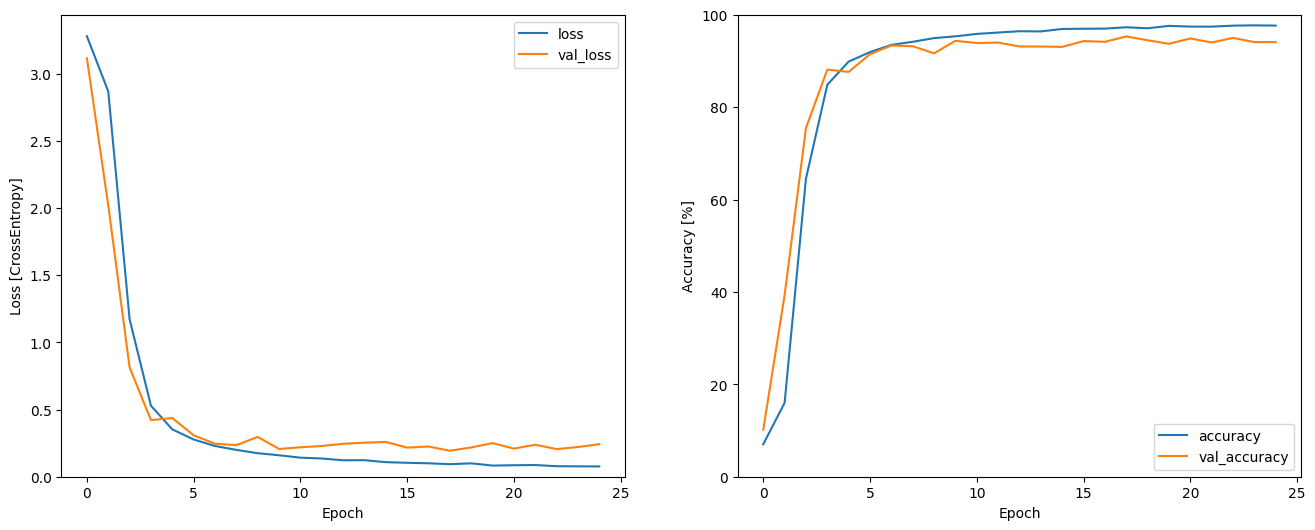

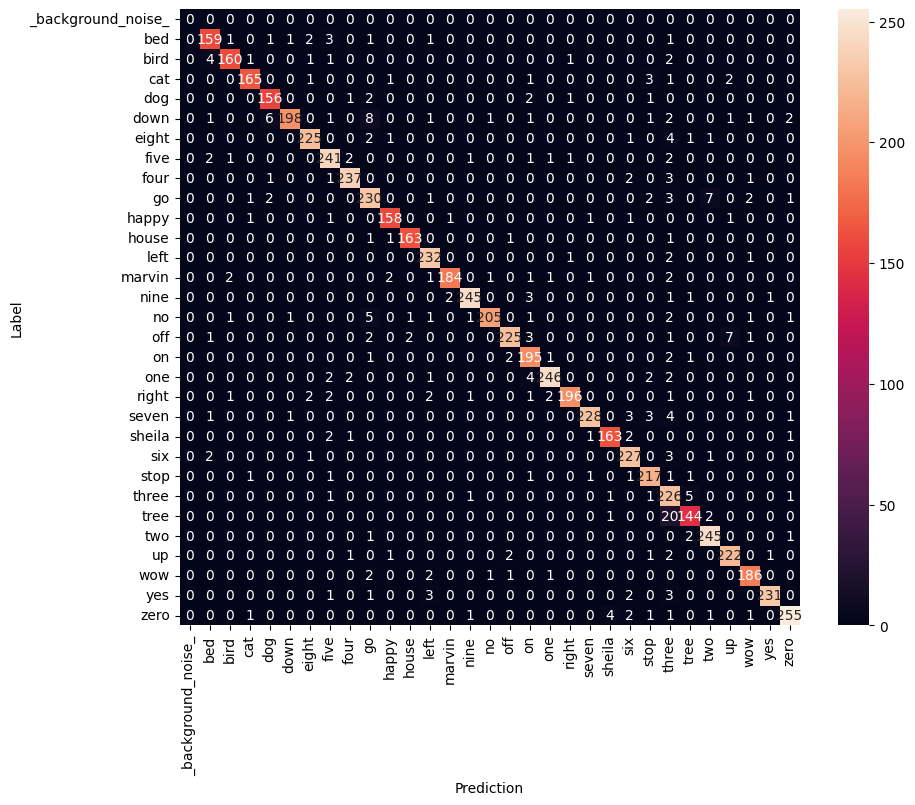

In [80]:
input_shape = example_spectrograms.shape[1:]
num_labels = len(label_names)

# Normalization layer
norm_layer = layers.Normalization()
norm_layer.adapt(train_spectrogram_ds.map(lambda spec, label: spec))

inputs = layers.Input(shape=input_shape)

# IMPORTANT: resize més gran per evitar pooling→0
x = layers.Resizing(96, 96)(inputs)
x = norm_layer(x)

# CNN block 1
x = layers.Conv2D(32, 5, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(padding="same")(x)

# CNN block 2
x = layers.Conv2D(64, 5, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(padding="same")(x)

# CNN block 3 
x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)

# Convert feature maps to temporal sequence
x = layers.Reshape((-1, 128))(x)

# Bidirectional GRU — segur i estable
x = layers.Bidirectional(layers.GRU(128))(x)

# Dropout només aquí (no dins CNN)
x = layers.Dropout(0.3)(x)

# Output
outputs = layers.Dense(num_labels, activation="softmax")(x)

model_Bidirectional_GRU = tf.keras.Model(inputs, outputs)
model_Bidirectional_GRU.summary()

model_Bidirectional_GRU.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=10,
        verbose=1,
        restore_best_weights=True 
    )
]

history = model_Bidirectional_GRU.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=25,
    callbacks=callbacks
)
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

model_Bidirectional_GRU.evaluate(test_spectrogram_ds, return_dict=True)
y_pred = model_Bidirectional_GRU.predict(test_spectrogram_ds)
y_pred = tf.argmax(y_pred, axis=1)
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## SpecAugment

Para aumentar la robustez del modelo, aplicamos SpecAugment sobre los Mel spectrograms
del conjunto de entrenamiento. Consiste en:

- **Frequency masking:** borrar bandas de frecuencia completas (aleatorio).
- **Time masking:** borrar intervalos temporales completos (aleatorio).

Esto equivale a un "random erasing" aplicado en dos ejes independientes, y
obliga al modelo a no depender de regiones específicas del espectrograma.
El resultado esperado es una mejor generalización y menor overfitting.


In [82]:
import tensorflow as tf
from tensorflow.keras import layers

# ===========================
# SpecAugment BATCH-SAFE
# ===========================
def spec_augment_tf(spec,
                    freq_mask_param=15,
                    time_mask_param=20,
                    num_freq_masks=2,
                    num_time_masks=2):
    spec = tf.identity(spec)

    B = tf.shape(spec)[0]
    T = tf.shape(spec)[1]
    F = tf.shape(spec)[2]

    # -------- Frequency masking --------
    for _ in range(num_freq_masks):
        f = tf.random.uniform([], 0, freq_mask_param + 1, dtype=tf.int32)
        f0 = tf.random.uniform([], 0, F - f + 1, dtype=tf.int32)

        freq_mask = tf.concat([
            tf.ones([f0], tf.float32),
            tf.zeros([f], tf.float32),
            tf.ones([F - f0 - f], tf.float32)
        ], axis=0)

        freq_mask = tf.reshape(freq_mask, [1, 1, F, 1])
        freq_mask = tf.broadcast_to(freq_mask, [B, T, F, 1])

        spec = spec * freq_mask

    # -------- Time masking --------
    for _ in range(num_time_masks):
        t = tf.random.uniform([], 0, time_mask_param + 1, dtype=tf.int32)
        t0 = tf.random.uniform([], 0, T - t + 1, dtype=tf.int32)

        time_mask = tf.concat([
            tf.ones([t0], tf.float32),
            tf.zeros([t], tf.float32),
            tf.ones([T - t0 - t], tf.float32)
        ], axis=0)

        time_mask = tf.reshape(time_mask, [1, T, 1, 1])
        time_mask = tf.broadcast_to(time_mask, [B, T, F, 1])

        spec = spec * time_mask

    return spec


# ===========================
# Dataset amb SpecAugment
# ===========================
train_ds_specaug = train_spectrogram_ds.map(
    lambda spec, label: (spec_augment_tf(spec), label),
    num_parallel_calls=tf.data.AUTOTUNE
)

# ===========================
# Model CNN + BiGRU
# ===========================
input_shape = example_spectrograms.shape[1:]
num_labels = len(label_names)

norm = layers.Normalization()
norm.adapt(train_spectrogram_ds.map(lambda s, l: s))

inputs = layers.Input(shape=input_shape)
x = layers.Resizing(96, 96)(inputs)
x = norm(x)

x = layers.Conv2D(32, 5, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(padding="same")(x)

x = layers.Conv2D(64, 5, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(padding="same")(x)

x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)

x = layers.Reshape((-1, 128))(x)
x = layers.Bidirectional(layers.GRU(128))(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(num_labels, activation="softmax")(x)

model_SpecAug = tf.keras.Model(inputs, outputs)
model_SpecAug.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=11,
        restore_best_weights=True,
        verbose=1
    )
]
model_SpecAug.fit(
    train_ds_specaug,
    validation_data=val_spectrogram_ds,
    epochs=25,
    callbacks=callbacks
)

Epoch 1/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 82s 97ms/step - accuracy: 0.0487 - loss: 3.3834 - val_accuracy: 0.0801 - val_loss: 3.2327
Epoch 2/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 78s 97ms/step - accuracy: 0.0790 - loss: 3.2411 - val_accuracy: 0.0755 - val_loss: 3.1986
Epoch 3/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 78s 97ms/step - accuracy: 0.0837 - loss: 3.1776 - val_accuracy: 0.1174 - val_loss: 3.0702
Epoch 4/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 79s 97ms/step - accuracy: 0.0900 - loss: 3.1943 - val_accuracy: 0.1406 - val_loss: 2.9363
Epoch 5/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 79s 97ms/step - accuracy: 0.1316 - loss: 2.9905 - val_accuracy: 0.1261 - val_loss: 2.9119
Epoch 6/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 79s 97ms/step - accuracy: 0.1953 - loss: 2.7181 - val_accuracy: 0.4833 - val_loss: 1.6979
Epoch 7/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 78s 97ms/step - accuracy: 0.4358 - loss: 1.8470 - val_accuracy: 0.6986 - val_loss: 1.0055
Epoch 8/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 79s 97ms/step - accuracy: 0.5913 - loss: 1.3475 - 

# **Random Erasing**

**Tipo de técnica:** Aumento de datos (data augmentation)  
**Dominio:** Espectrogramas tiempo–frecuencia  
**Aplicación:** Solo durante el entrenamiento  

**Descripción del método:**
- Se aplica Random Erasing directamente sobre los mel-espectrogramas
- Se elimina aleatoriamente un parche rectangular del espectrograma
- El tamaño y la posición del parche se eligen de forma aleatoria
- La operación se aplica con una probabilidad fija a cada ejemplo

**Características principales:**
- Técnica de regularización fuerte
- Obliga al modelo a no depender de regiones locales concretas
- Aumenta la robustez frente a ruido, oclusiones y variabilidad acústica
- No modifica la arquitectura del modelo

**Configuración experimental:**
- El modelo utilizado es idéntico al modelo base
- La única diferencia es la aplicación de Random Erasing en el conjunto de entrenamiento
- Validación y test se mantienen sin augmentación

**Objetivo del experimento:**  
Evaluar el impacto del aumento de datos mediante Random Erasing en la capacidad de generalización del modelo, aislando su efecto respecto a la arquitectura.


# **SpecAugment + Random Erasing**

**Tipo de técnica:** Aumento de datos (data augmentation)  
**Dominio:** Espectrogramas tiempo–frecuencia  
**Aplicación:** Exclusivamente durante el entrenamiento  

**Descripción del método:**
- Se aplica SpecAugment para enmascarar bandas temporales y de frecuencia
- Posteriormente se aplica Random Erasing para eliminar parches rectangulares
- Ambas transformaciones se realizan de forma aleatoria y secuencial
- El orden de aplicación es SpecAugment → Random Erasing

**Características principales:**
- Combina augmentación estructurada (SpecAugment) con augmentación agresiva (Random Erasing)
- Incrementa significativamente la diversidad de los datos de entrenamiento
- Actúa como un mecanismo de regularización fuerte
- No altera la arquitectura del modelo

**Configuración experimental:**
- El modelo utilizado es idéntico al modelo base
- Solo el conjunto de entrenamiento es aumentado
- Validación y test se mantienen sin modificaciones

**Objetivo del experimento:**  
Analizar si la combinación de distintas técnicas de aumento de datos mejora la capacidad de generalización del modelo frente al uso de augmentación individual o la ausencia de augmentación.


In [83]:
import tensorflow as tf
from tensorflow.keras import layers

# ===========================
# Random Erasing (estable)
# ===========================
import tensorflow as tf
from tensorflow.keras import layers

# ===========================
# Random Erasing BATCH-SAFE
# ===========================
def random_erasing_tf(spec, p=0.5, max_area=0.15):
    """
    Random Erasing per espectrogramas amb shape:
    (B, T, F, 1)
    """

    spec = tf.identity(spec)

    B = tf.shape(spec)[0]
    T = tf.shape(spec)[1]
    F = tf.shape(spec)[2]

    def apply_erasing():
        area = tf.cast(T * F, tf.float32)
        erase_area = area * tf.random.uniform([], 0.02, max_area)
        aspect = tf.random.uniform([], 0.3, 3.0)

        h = tf.cast(tf.sqrt(erase_area / aspect), tf.int32)
        w = tf.cast(tf.sqrt(erase_area * aspect), tf.int32)

        h = tf.clip_by_value(h, 1, T)
        w = tf.clip_by_value(w, 1, F)

        t0 = tf.random.uniform([], 0, T - h + 1, tf.int32)
        f0 = tf.random.uniform([], 0, F - w + 1, tf.int32)

        time_mask = tf.concat([
            tf.ones([t0]),
            tf.zeros([h]),
            tf.ones([T - t0 - h])
        ], axis=0)

        freq_mask = tf.concat([
            tf.ones([f0]),
            tf.zeros([w]),
            tf.ones([F - f0 - w])
        ], axis=0)

        mask = tf.reshape(time_mask, [1, T, 1, 1]) * \
               tf.reshape(freq_mask, [1, 1, F, 1])

        mask = tf.broadcast_to(mask, [B, T, F, 1])
        return spec * mask

    return tf.cond(
        tf.random.uniform([]) < p,
        apply_erasing,
        lambda: spec
    )


# ===========================
# Dataset amb Random Erasing
# ===========================
train_ds_re = train_spectrogram_ds.map(
    lambda spec, label: (random_erasing_tf(spec), label),
    num_parallel_calls=tf.data.AUTOTUNE
)


# ===========================
# Modelo (idéntico)
# ===========================
model_RandomErasing = tf.keras.models.clone_model(model_SpecAug)
model_RandomErasing.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=11,
        restore_best_weights=True,
        verbose=1
    )
]
model_RandomErasing.fit(
    train_ds_re,
    validation_data=val_spectrogram_ds,
    epochs=25,
    callbacks = callbacks
)


Epoch 1/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 82s 97ms/step - accuracy: 0.0480 - loss: 3.3828 - val_accuracy: 0.0820 - val_loss: 3.2042
Epoch 2/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 78s 96ms/step - accuracy: 0.0788 - loss: 3.2361 - val_accuracy: 0.1453 - val_loss: 2.9328
Epoch 3/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 78s 96ms/step - accuracy: 0.1277 - loss: 3.0045 - val_accuracy: 0.1417 - val_loss: 2.8618
Epoch 4/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 78s 96ms/step - accuracy: 0.2004 - loss: 2.6919 - val_accuracy: 0.6180 - val_loss: 1.3441
Epoch 5/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 78s 96ms/step - accuracy: 0.5000 - loss: 1.6757 - val_accuracy: 0.8165 - val_loss: 0.6549
Epoch 6/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 78s 97ms/step - accuracy: 0.6388 - loss: 1.2150 - val_accuracy: 0.8668 - val_loss: 0.4645
Epoch 7/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 78s 96ms/step - accuracy: 0.6984 - loss: 1.0060 - val_accuracy: 0.8762 - val_loss: 0.4266
Epoch 8/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 78s 97ms/step - accuracy: 0.7344 - loss: 0.8921 - 

In [87]:
train_ds_specaug_re = train_spectrogram_ds.map(
    lambda spec, label: (random_erasing_tf(spec_augment_tf(spec)), label),
    num_parallel_calls=tf.data.AUTOTUNE
)

model_SpecAug_RE = tf.keras.models.clone_model(model_SpecAug)
model_SpecAug_RE.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=11,
        restore_best_weights=True,
        verbose=1
    )
]
model_SpecAug_RE.fit(
    train_ds_specaug_re,
    validation_data=val_spectrogram_ds,
    epochs=25,
    callbacks = callbacks
)


Epoch 1/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 81s 96ms/step - accuracy: 0.0479 - loss: 3.3911 - val_accuracy: 0.0761 - val_loss: 3.2137
Epoch 2/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 77s 96ms/step - accuracy: 0.0677 - loss: 3.2827 - val_accuracy: 0.0882 - val_loss: 3.1808
Epoch 3/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 77s 95ms/step - accuracy: 0.0781 - loss: 3.2506 - val_accuracy: 0.1012 - val_loss: 3.0096
Epoch 4/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 77s 96ms/step - accuracy: 0.0960 - loss: 3.1114 - val_accuracy: 0.2044 - val_loss: 2.6669
Epoch 5/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 77s 95ms/step - accuracy: 0.1788 - loss: 2.7740 - val_accuracy: 0.4862 - val_loss: 1.7003
Epoch 6/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 77s 96ms/step - accuracy: 0.3523 - loss: 2.1597 - val_accuracy: 0.7022 - val_loss: 1.0436
Epoch 7/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 77s 96ms/step - accuracy: 0.4903 - loss: 1.7078 - val_accuracy: 0.8034 - val_loss: 0.7298
Epoch 8/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 77s 95ms/step - accuracy: 0.5649 - loss: 1.4586 - 

### Arquitectura híbrida CNN–BiGRU con Data Augmentation integrado


**Tipo de arquitectura:** Modelo híbrido convolucional–recurrente  
**Entrada:** Mel-espectrogramas  
**Preprocesamiento:** Redimensionado a 96×96 y normalización  
**Aumento de datos:** Integrado dentro del modelo (solo en entrenamiento)

**Estructura del modelo:**
- Capa de data augmentation aplicada directamente sobre la entrada
  - Desplazamientos y escalados aleatorios en el dominio tiempo–frecuencia
- Tres bloques convolucionales para extracción de características locales
- Reorganización de mapas de características como secuencia temporal
- Capa GRU bidireccional para modelar dependencias temporales
- Capa de dropout para regularización
- Capa densa final con activación softmax

**Características principales:**
- Combina extracción espacial (CNN) y modelado temporal (RNN)
- El data augmentation se aplica únicamente durante el entrenamiento
- Arquitectura más robusta frente a variabilidad acústica
- No se modifica el conjunto de validación ni de test

**Objetivo del experimento:**  
Evaluar el impacto de incorporar técnicas de aumento de datos directamente en el modelo y analizar si esta estrategia mejora la generalización frente a la misma arquitectura sin augmentación.


In [85]:
import tensorflow as tf
from tensorflow.keras import layers, models

# ===========================
# DATA AUGMENTATION LAYER
# ===========================
data_augmentation = tf.keras.Sequential([
    # Simula SpecAugment de forma segura
    layers.RandomTranslation(
        height_factor=0.05,   # time masking suave
        width_factor=0.05     # freq masking suave
    ),
    layers.RandomZoom(
        height_factor=0.1,
        width_factor=0.1
    )
], name="data_augmentation")


# ===========================
# BUILD MODEL (CNN + BiGRU)
# ===========================
input_shape = example_spectrograms.shape[1:]
num_labels = len(label_names)

norm_layer = layers.Normalization()
norm_layer.adapt(train_spectrogram_ds.map(lambda spec, label: spec))

inputs = layers.Input(shape=input_shape)

x = data_augmentation(inputs)

x = layers.Resizing(96, 96)(x)
x = norm_layer(x)

# CNN block 1
x = layers.Conv2D(32, 5, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(padding="same")(x)

# CNN block 2
x = layers.Conv2D(64, 5, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(padding="same")(x)

# CNN block 3
x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
x = layers.BatchNormalization()(x)

# CNN → RNN
x = layers.Reshape((-1, 128))(x)

# Bidirectional GRU
x = layers.Bidirectional(layers.GRU(128))(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(num_labels, activation="softmax")(x)

model_Augmented = tf.keras.Model(inputs, outputs, name="CNN_BiGRU_Augmented")
model_Augmented.summary()


# ===========================
# COMPILE
# ===========================
model_Augmented.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)


# ===========================
# CALLBACKS
# ===========================
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=7,
        restore_best_weights=True,
        verbose=1
    )
]


# ===========================
# TRAIN
# ===========================
history = model_Augmented.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=25,
    callbacks=callbacks
)


Model: "CNN_BiGRU_Augmented"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 124, 64, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 124, 64, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resizing_10 (Resizing)          │ (None, 96, 96, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization_10                │ (None, 96, 96, 1)      │             3 │
│ (Normalization)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 96, 96, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 48, 48, 64)     │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_5 (Reshape)             │ (None, 576, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 256)            │       198,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 31)             │         7,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,962 (1.27 MB)

 Trainable params: 332,511 (1.27 MB)

 Non-trainable params: 451 (1.77 KB)

Epoch 1/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 83s 98ms/step - accuracy: 0.0543 - loss: 3.3623 - val_accuracy: 0.1332 - val_loss: 2.9155
Epoch 2/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 79s 97ms/step - accuracy: 0.1536 - loss: 2.8893 - val_accuracy: 0.2964 - val_loss: 2.3191
Epoch 3/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 79s 97ms/step - accuracy: 0.3735 - loss: 2.0023 - val_accuracy: 0.4910 - val_loss: 1.6650
Epoch 4/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 79s 97ms/step - accuracy: 0.6125 - loss: 1.2464 - val_accuracy: 0.7345 - val_loss: 0.9215
Epoch 5/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 79s 97ms/step - accuracy: 0.8001 - loss: 0.6758 - val_accuracy: 0.8592 - val_loss: 0.5031
Epoch 6/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 79s 97ms/step - accuracy: 0.8651 - loss: 0.4730 - val_accuracy: 0.7771 - val_loss: 0.7992
Epoch 7/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 79s 97ms/step - accuracy: 0.8927 - loss: 0.3758 - val_accuracy: 0.8813 - val_loss: 0.3988
Epoch 8/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 79s 97ms/step - accuracy: 0.9055 - loss: 0.3251 - 

### Arquitectura Conformer (CNN + Self-Attention)

**Tipo de arquitectura:** Modelo híbrido convolucional con atención  
**Entrada:** Mel-espectrogramas  
**Preprocesamiento:** Redimensionado a 96×96 y normalización  

**Estructura del modelo:**
- Front-end convolucional para extracción de características locales
  - Tres capas Conv2D con normalización por lotes
  - Reducción progresiva mediante max pooling
- Conversión de los mapas convolucionales en una secuencia temporal
- Codificación posicional entrenable añadida a la secuencia
- Dos bloques Conformer simplificados:
  - Capas feed-forward
  - Atención multi-cabeza (self-attention)
  - Conexiones residuales y normalización
- Global Average Pooling temporal
- Capa de dropout para regularización
- Capa densa final con activación softmax

**Características principales:**
- Combina extracción local (CNN) y modelado de dependencias temporales largas (self-attention)
- Captura relaciones globales en el dominio tiempo–frecuencia
- Más expresivo que CNN y CNN–RNN, a costa de mayor complejidad computacional

**Objetivo del experimento:**  
Evaluar el rendimiento de una arquitectura basada en atención tipo Conformer y compararla con modelos convolucionales, recurrentes y arquitecturas híbridas en la tarea de reconocimiento de comandos de voz.


In [86]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Positional Encoding (Keras-safe)
class PositionalEncoding(layers.Layer):
    def __init__(self, max_len, d_model):
        super().__init__()
        self.pos_emb = layers.Embedding(
            input_dim=max_len,
            output_dim=d_model
        )

    def call(self, x):
        seq_len = tf.shape(x)[1]
        positions = tf.range(start=0, limit=seq_len, delta=1)
        pos_encoding = self.pos_emb(positions)
        return x + pos_encoding


# Conformer Block (simplificado)
def conformer_block(x, num_heads, d_model, ff_dim, dropout=0.1):
    # Feed Forward 1
    ff1 = layers.Dense(ff_dim, activation="relu")(x)
    ff1 = layers.Dropout(dropout)(ff1)
    ff1 = layers.Dense(d_model)(ff1)
    x = layers.Add()([x, ff1])
    x = layers.LayerNormalization()(x)

    # Multi-Head Self Attention
    attn = layers.MultiHeadAttention(
        num_heads=num_heads,
        key_dim=d_model // num_heads,
        dropout=dropout
    )(x, x)
    x = layers.Add()([x, attn])
    x = layers.LayerNormalization()(x)

    # Feed Forward 2
    ff2 = layers.Dense(ff_dim, activation="relu")(x)
    ff2 = layers.Dropout(dropout)(ff2)
    ff2 = layers.Dense(d_model)(ff2)
    x = layers.Add()([x, ff2])
    x = layers.LayerNormalization()(x)

    return x


# BUILD CONFORMER MODEL
input_shape = example_spectrograms.shape[1:]
num_labels = len(label_names)

# Normalization
norm_layer = layers.Normalization()
norm_layer.adapt(train_spectrogram_ds.map(lambda spec, label: spec))

inputs = layers.Input(shape=input_shape)

# Preprocess
x = layers.Resizing(96, 96)(inputs)
x = norm_layer(x)

# CNN front-end
x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(padding="same")(x)

x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling2D(padding="same")(x)

x = layers.Conv2D(128, 3, padding="same", activation="relu")(x)
x = layers.BatchNormalization()(x)

# CNN → sequence
x = layers.Reshape((-1, 128))(x)

# Positional Encoding
x = PositionalEncoding(max_len=5000, d_model=128)(x)

# Conformer blocks
x = conformer_block(
    x,
    num_heads=4,
    d_model=128,
    ff_dim=256,
    dropout=0.1
)

x = conformer_block(
    x,
    num_heads=4,
    d_model=128,
    ff_dim=256,
    dropout=0.1
)

# Pool + Classifier
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.3)(x)

outputs = layers.Dense(num_labels, activation="softmax")(x)

model_Conformer = tf.keras.Model(
    inputs, outputs, name="Conformer_CNN_Attention"
)

model_Conformer.summary()



# COMPILE
model_Conformer.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)


# CALLBACKS
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=7,
        restore_best_weights=True,
        verbose=1
    )
]


# TRAIN
history = model_Conformer.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=25,
    callbacks=callbacks
)


Model: "Conformer_CNN_Attention"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 124, 64,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_11         │ (None, 96, 96, 1) │          0 │ input_layer_12[0… │
│ (Resizing)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_11    │ (None, 96, 96, 1) │          3 │ resizing_11[0][0] │
│ (Normalization)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 96, 96,    │        320 │ normalization_11… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 96, 96,    │        128 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_15    │ (None, 48, 48,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 48, 48,    │     18,496 │ max_pooling2d_15… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 48, 48,    │        256 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 24, 24,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 24, 24,    │     73,856 │ max_pooling2d_16… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 24, 24,    │        512 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, 576, 128)  │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 576, 128)  │    640,000 │ reshape_6[0][0]   │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 576, 256)  │     33,024 │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 576, 256)  │          0 │ dense_15[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 576, 128)  │     32,896 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 576, 128)  │          0 │ positional_encod… │
│                     │                   │            │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 576, 128)  │        256 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 1,134,882 (4.33 MB)

 Trainable params: 1,134,431 (4.33 MB)

 Non-trainable params: 451 (1.77 KB)

Epoch 1/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 90s 90ms/step - accuracy: 0.0833 - loss: 3.2881 - val_accuracy: 0.4135 - val_loss: 2.0093
Epoch 2/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 62s 77ms/step - accuracy: 0.4737 - loss: 1.7513 - val_accuracy: 0.7104 - val_loss: 1.0167
Epoch 3/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 62s 77ms/step - accuracy: 0.7345 - loss: 0.9173 - val_accuracy: 0.7949 - val_loss: 0.7130
Epoch 4/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 62s 77ms/step - accuracy: 0.8225 - loss: 0.6243 - val_accuracy: 0.8541 - val_loss: 0.5066
Epoch 5/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 62s 76ms/step - accuracy: 0.8560 - loss: 0.4966 - val_accuracy: 0.8603 - val_loss: 0.4945
Epoch 6/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 61s 76ms/step - accuracy: 0.8802 - loss: 0.4135 - val_accuracy: 0.8651 - val_loss: 0.4890
Epoch 7/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 61s 75ms/step - accuracy: 0.8974 - loss: 0.3560 - val_accuracy: 0.8959 - val_loss: 0.3661
Epoch 8/25
810/810 ━━━━━━━━━━━━━━━━━━━━ 61s 75ms/step - accuracy: 0.9058 - loss: 0.3293 - 

## Generate the submission file

The code below produces the `submission.csv` file, which you are required to submit for the competition. **Please do not make any changes in this cell**. 

In [ ]:
import pandas as pd

l = [[i,j] for i,j in zip(list(range(1,len(y_pred)+1)), y_pred.numpy().tolist())]

df = pd.DataFrame(l, columns=['ID','labels'])

df.to_csv('submission.csv', index=False)